<a href="https://colab.research.google.com/github/kenichinakanishi/houseplant_classifier/blob/master/Part_5_Regularization_with_Image_Aug_and_Label_Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Unzip the File

The use of images directly from a google drive is very slow.
This is because even though the drive appears to be direcly attached to our colab instance, in actuality we are dynamically downloading and accessing each image one by one - leading to extremely long training times. 

At this point, I've gone to the directory the image files were downloaded to, zipped them up and placed that master zip file into my google drive for importing and processing. 

In [2]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database_manualcleanedlosses10.zip' 'plant_images_database_manualcleanedlosses10.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database_manualcleanedlosses10.zip" -d "/content";

plant_images_database_manualcleanedlosses10/Citrus ×aurantium/:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000003.jpg: 

In [3]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database.zip' 'plant_images_database.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database.zip" -d "/content";

plant_image_database/Citrus ×aurantium/:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000003.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000003.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000004.jpg:  mismatching "lo

# Imports

In [4]:
# Check GPU on Colabs
# NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2
! nvidia-smi 

Tue Jan  5 08:19:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install -U scikit-learn -q
import sklearn

     |████████████████████████████████| 22.2MB 1.5MB/s 


In [6]:
# Run once per session
!pip install fastai==2.1.2 -q
!pip install fastcore==1.3.1 -q
!pip install torch==1.7.0 -q
import fastai
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastcore.script import *
fastprogress.MAX_COLS = 80

     |████████████████████████████████| 194kB 4.3MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 51kB 2.8MB/s 


In [7]:
# Import source of efficientnet models and weights
!pip install geffnet -q
import geffnet

! pip install pytorchcv torch>=0.4.0 -q
from pytorchcv.model_provider import get_model as ptcv_get_model

In [8]:
torch.cuda.is_available()

True

In [9]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil -q
!pip install psutil -q
!pip install humanize -q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [10]:
printm()

Gen RAM Free: 26.1 GB  | Proc size: 312.3 MB
GPU RAM Free: 16120MB | Used: 10MB | Util   0% | Total 16130MB


# Set Up Model

In [11]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [12]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path)):
      num_files = len(sorted(os.listdir(path+'/'+folder)))
      cut_point = int(num_files*pct_images)
      # Takes the first pct_images from each folder
      if shuffle == True:
        for file in shuff(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
      else:
        for file in sorted(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
  df = pd.DataFrame(data, columns=['Class', 'Path'])
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)} images.) Shuffle = {shuffle}.')
  return df

In [13]:
@call_parse
def stratified_split(
      dataframe: Param("DataFrame created from create_path_df, containing Class and Path columns."), 
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      random_state: Param("Fix randomness if shuffle==True", int)=101,
      ):
  ''' 
  Prepares a stratified k-fold split from a dataframe with 'Class' and 'Path' by adding an 'is_valid' column.

  Returns:
  ----------
  DataFrame
    Returns the requested stratified k-fold split by adding an 'is_valid' column. 
  '''
  from sklearn.model_selection import StratifiedKFold
  # Create stratified split using sklearn
  print(f'Preparing stratified {n_splits} fold split, random state is {random_state}. Returning fold {fold}.')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
  X, y = dataframe['Path'], dataframe['Class']
  splits = list(kf.split(X, y))
  # Prepare the selected fold
  fold = fold
  train_df = dataframe.loc[splits[fold][0]]
  val_df = dataframe.loc[splits[fold][1]]
  train_df['is_valid'] = False
  val_df['is_valid'] = True
  df_cnn = train_df.append(val_df)
  # Return the selected fold
  return df_cnn

In [14]:
@call_parse
def get_dataloader(
      img_path: Param("Path of images to use", str) = None,
      split_path: Param("Path of images to use to pre-define split", str)=None,
      image_df: Param("Dataframe with Class and Path", pd.DataFrame)=None,
      img_size:  Param("Size in pixels", int)=224,
      pct_images: Param("Fraction of images to use", float)=1,
      bs: Param("Batch size", int)=64,
      deterministic: Param("Deterministic learner", bool)=True,
      randomerasing: Param("Random Erasing", str)=None,
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      ):
  """ 
  Takes in image path or dataframe and creates a dataloader. 
  If a split_path is defined, uses the entirety of that path to generate a master split, onto which the img_path is joined to defined a pseudo split.  
  If a image_df is defined, uses that dataframe to generate train/test split. 
  Returns:
  ----------
  Dataloader
    dls = data.dataloaders(df_cnn_mini, bs=bs)
  """

  # Get file path and labels from the dataframe we set up.
  get_x = lambda x: x['Path']
  get_y = lambda y: y['Class']
  # Define splitting function that reads from a dataframe column.
  def stratifiedsplitter(df):      
      train = df.index[~df['is_valid']].tolist()
      valid = df.index[df['is_valid']].tolist()
      return train,valid   
  # Prepare transforms
    # Image is larger initially (512 px) for later augmentations.
  item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
    # Batch transformations include a random resized crop to img_size px. 
  batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  # Add in randomerasing if necessary.
  if randomerasing != None:
    batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  # Prepare DataBlock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=stratifiedsplitter,            # Stratified train/validation split
                    get_x=get_x,                            # Get the image path from dataframe
                    get_y=get_y,                            # Label from dataframe
                    item_tfms=item_tfms,                    # Crop images to a square
                    batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats
  if image_df is not None and pct_images != 1:
    print(f'Image dataframe defined, reducing number of images to {pct_images*100}% and preparing stratified split.')
    image_df = image_df.reset_index().drop(columns='index')
    kf = StratifiedShuffleSplit(n_splits=1, random_state = 101, test_size=pct_images)
    X, y = image_df['Path'], image_df['Class']
    splits = list(kf.split(X, y))
    reduced_df = image_df.loc[splits[0][1]]
    reduced_df = reduced_df.reset_index().drop(columns='index')
    df_cnn_mini = stratified_split(reduced_df, n_splits = 5, shuffle = True, random_state = 101, fold = fold)
  elif image_df is not None and pct_images == 1:
    print(f'Image dataframe defined, preparing stratified split.')
    df_cnn_mini = stratified_split(image_df, n_splits = 5, shuffle = True, random_state = 101, fold = fold)
  elif split_path != None and img_path != None:
    print('Split Path defined, preparing pseudo stratified split.')
    # Create split_df - a dataframe that defines a master split, based on split_path
    df = create_path_df(split_path, pct_images=1)
    split_df = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = fold)
    split_df['Path']= split_df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-2:]))
    # Inner join this reduced dataframe to the previous splits to maintain the same training images
    df_mini = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini= df_mini.merge(split_df, how = 'inner', on = ['Class','Path'])
  elif img_path != None: 
    # Create a dataframe based on main image path with a (possibly) reduced number of images
    df = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = fold)
  # Print some information for a sanity check
  dls = data.dataloaders(df_cnn_mini, bs=bs)
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {split_df['is_valid'].describe()['freq']/len(split_df['is_valid'])*100:.2f}% training data with {len(split_df.groupby('Class').count())} classes, the reduced split has {df_cnn_mini['is_valid'].describe()['freq']/len(df_cnn_mini['is_valid'])*100:.2f} % training data, with {len(df_cnn_mini.groupby('Class').count())} classes.")
  return dls

In [15]:
@call_parse
def create_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='adam',
        arch:  Param("Architecture", str)='resnet34',
        custom_head:  Param("Use of custom head", nn.Sequential)=None,
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        image_df: Param("Dataframe with Class and Path", pd.DataFrame)=None,
        img_path: Param("Path of images to use", str)=None,
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        loss_func: Param("Learner loss function", str)=None,
        cbs: Param("Additional callbacks such as Mixup or CutMix", str)=None,
        randomerasing: Param("Random Erasing", str)=None,
        fold: Param("Which fold to use", int)=0,
        ):
    # Select optimization function
    if   opt=='adam'  : opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=0.99, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='ranger': opt_func = partial(ranger, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)
    elif opt!=None : opt_func = opt
    # Get DataLoader
    if deterministic == True:
      random_seed(101,True)
    # Implement RandomErasing
    if randomerasing != None:
      dls = get_dataloader(img_size = size, bs = bs, image_df=image_df, img_path=img_path, split_path=split_path, pct_images=pct_images, randomerasing=randomerasing, fold=fold)
    else: 
      dls = get_dataloader(img_size = size, bs = bs, image_df=image_df, img_path=img_path, split_path=split_path, pct_images=pct_images, fold=fold)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    if cbs is not None:
      if type(cbs) is list: callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()] + cbs
      else: callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), cbs]
    # Setup Learner
    f1_score_multi = F1Score(average="macro")
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        config = {'custom_head':custom_head},
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy,f1_score_multi], 
                        model_dir = model_dir,
                        loss_func = loss_func,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [16]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

# Model Exploration

In [17]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

# Create Test Set

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
df = create_path_df('/content/plant_images_database_manualcleanedlosses10/', pct_images=1)
kf = StratifiedShuffleSplit(n_splits=5, random_state = 101, test_size=0.2)
X, y = df['Path'], df['Class']
splits = list(kf.split(X, y))
fold = 0
train_df = df.loc[splits[0][0]].reset_index().drop('index',axis=1)
test_df = df.loc[splits[0][1]].reset_index().drop('index',axis=1)

Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 100.00% of the images (68519 images.) Shuffle = False.


In [19]:
test_df

Class                                                                                        Path
0             Stevia rebaudiana         /content/plant_images_database_manualcleanedlosses10/Stevia rebaudiana/00000048.jpg
1                     Amaryllis                 /content/plant_images_database_manualcleanedlosses10/Amaryllis/00000300.jpg
2       Dimorphotheca pluvialis   /content/plant_images_database_manualcleanedlosses10/Dimorphotheca pluvialis/00000238.jpg
3             Pilea microphylla         /content/plant_images_database_manualcleanedlosses10/Pilea microphylla/00000007.jpg
4          Incarvillea delavayi      /content/plant_images_database_manualcleanedlosses10/Incarvillea delavayi/00000119.jpg
...                         ...                                                                                         ...
13699         Ligustrum vulgare         /content/plant_images_database_manualcleanedlosses10/Ligustrum vulgare/00000005.jpg
13700  Darlingtonia californica  /content/plant_images_database_manualcleanedlosses10/Darlingtonia californica/00000275.jpg
13701                  Calathea                  /content/plant_images_database_manualcleanedlosses10/Calathea/00000153.jpg
13702              Hemerocallis              /content/plant_images_database_manualcleanedlosses10/Hemerocallis/00000056.jpg
13703     Dendrophylax lindenii     /content/plant_images_database_manualcleanedlosses10/Dendrophylax lindenii/00000263.jpg

[13704 rows x 2 columns]

# Create Test DataLoader

In [20]:
train = train_df.copy().reset_index().drop(columns='index')
train['is_test'] = False
test = test_df.copy().reset_index().drop(columns='index')
test['is_test'] = True 
train_test_df = train.append(test)
train_test_df = train_test_df.reset_index().drop(columns='index')

In [21]:
# Get file path and labels from the dataframe we set up.
get_x = lambda x: x['Path']
get_y = lambda y: y['Class']
# Define splitting function that reads from a dataframe column.
def testsplit(df):      
    train = df.index[~df['is_test']].tolist()
    valid = df.index[df['is_test']].tolist()
    return train,valid   
# Prepare transforms
  # Image is larger initially (512 px) for later augmentations.
item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
  # Batch transformations include a random resized crop to img_size px. 
batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
# Prepare DataBlock
data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter=testsplit,                     # Everything is test
                  get_x=get_x,                            # Get the image path from dataframe
                  get_y=get_y,                            # Label from dataframe
                  item_tfms=item_tfms,                    # Crop images to a square
                  batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats\


test_dl = data.dataloaders(train_test_df, bs=64)

In [22]:
# Get predictions from the dataloader
def get_test_accuracy(learn):
  _,true,preds = learn.get_preds(dl = test_dl.valid, with_input=False, with_decoded=True)
  accuracy = len([True for a,b in zip(preds.tolist(),true.tolist()) if a==b])/len(preds.tolist())
  print(f'Accuracy on holdout test set = {accuracy:.4f}')
  return accuracy

# Custom TestAccuracyCallback

In [23]:
class TestAccuracyCallback(Callback):
    "A callback to fetch predictions during the training loop"
    remove_on_fetch = True
    def __init__(self, holdout_dl, fname='test_accuracy.csv', ds_idx=1, report_freq=10, with_input=False, with_decoded=True, cbs=None, reorder=True):
        self.cbs = L(cbs)
        self.report_freq = report_freq
        self.holdout_dl = holdout_dl
        self.fname = Path(fname)
        store_attr('ds_idx,with_input,with_decoded,reorder')

    def read_log(self):
        "Convenience method to quickly access the log."
        return pd.read_csv(self.path/self.fname)

    def before_fit(self):
        "Prepare file with for later."
        if hasattr(self, "gather_preds"): return
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.file = (self.path/self.fname).open('w')
        self.file.write('Accuracy of predictions on Test Set' + '\n')
        self.main_loss_func = self.learn.loss_func

    def after_validate(self):
        "Run a prediction on the test set and calculate simple accuracy, print to file"
        current_epoch = self.epoch
        if (self.epoch+1)%self.report_freq == 0:
          # Remove interfering callbacks
          to_rm = L(cb for cb in self.learn.cbs if getattr(cb, 'remove_on_fetch', False))
          cbs_rm = L([i for i in self.learn.cbs if 'Mix' in str(i)])
          with self.learn.removed_cbs(to_rm + self.cbs + cbs_rm) as learn:
              # If a Mix image augmentation is present, we need to adjust the loss function
              if cbs_rm :
                saved_lf = learn.loss_func
                learn.loss_func = self.main_loss_func
              raw,targ,pre = learn.get_preds(ds_idx=self.ds_idx, 
                                           dl=self.holdout_dl,
                                           with_input=self.with_input, 
                                           with_decoded=True, 
                                           inner=True, # Avoid recursion since we're within a training session
                                           reorder=self.reorder)
              skaccuracy = sklearn.metrics.accuracy_score(targ,pre)
              print(f'Accuracy epoch {current_epoch} :{skaccuracy}')
              topacc = sklearn.metrics.top_k_accuracy_score(targ, raw, k=5, labels = list(range(0,learn.dls.c)))
              print(f'Top-5 Accuracy epoch {current_epoch} :{topacc}')
              fscore = sklearn.metrics.f1_score(targ, pre, average='macro', labels=list(range(0,learn.dls.c)))
              print(f'Macro F1-Score Accuracy epoch {current_epoch} :{fscore}')
              # Restore the changed loss function
              if cbs_rm : learn.loss_func = saved_lf
              # Write to the file we created.
              self.file.write(f'{accuracy}' + '\n')
              self.file.flush()
              os.fsync(self.file.fileno())

    def after_fit(self):
        "Close the file and clean up."
        if hasattr(self, "gather_preds"): return
        self.file.close()

The inference is messed up if the Mix callbacks are in the learner at inference time. Hence we grab out the learn.loss_func before train and use that during inference. We need to then keep the image augmentation after the TestAccuracyCallback

## Example Usage

In [24]:
# # We wrap the PyTorchCV implementation into the torchvision model API
# # Each model should be present as a function in the global namespace 
# def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
#   model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
#   model = change_act(model, pre_act = geffnet.activations_me.SwishMe, post_act = Mish())
#   return model

# # Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
# def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

# model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
#                            'split': _efficientnet_b3_split, 
#                            'stats': imagenet_stats}

# learn = create_cnn_learner(pct_images=0.1, 
#                            deterministic=True, 
#                            size=112, 
#                            arch = 'tf_efficientnet_b3_ns_customsplit_mish',
#                            pretrained=True,
#                            image_df = train_df,
#                            bs = 56*4,
#                            )

In [25]:
#The inference is messed up if the Mix callbacks are in the learner at inference time
  # Keep the image augmentation after the TestAccuracyCallback

# learn.fit_one_cycle(2, 
#                     lr_max=slice(1e-3, 1e-2), 
#                     cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=1, fname = 'FMix_test_accuracy.csv'), FMix()]
#                     )


# FMix
Code adapted from https://gist.github.com/tank671/7bbdd4b9155fcdd712d7a4bd4a99001e


FMix is a data augmentation technique described in Harris et al., 2020 (https://arxiv.org/pdf/2002.12047). It is similar to CutMix, which takes randomly-selected rectangles of images and exchanges them within a batch. The key difference is that instead of using rectangles as regions of exchange, FMix uses more complicated shapes with irregular boundaries.

The official implementation is at https://github.com/ecs-vlc/FMix. The functions in the following cell, which are used to generate the masks, are taken from there.

In [26]:
from torch.distributions.beta import Beta

def fftfreqnd(h, w=None, z=None):
    """ Get bin values for discrete fourier transform of size (h, w, z)
    From https://github.com/ecs-vlc/FMix """
    fz = fx = 0
    fy = np.fft.fftfreq(h)
    if w is not None:
        fy = np.expand_dims(fy, -1)
        fx = np.fft.fftfreq(w)[: w // 2 + 2] if (w % 2 == 1) else np.fft.fftfreq(w)[: w // 2 + 1]
    if z is not None:
        fy = np.expand_dims(fy, -1)
        fz = np.fft.fftfreq(z)[:, None] if z % 2 == 1 else np.fft.fftfreq(z)[:, None]
    return np.sqrt(fx * fx + fy * fy + fz * fz)

def get_spectrum(freqs, decay_power, ch, h, w=0, z=0):
    """ Samples a fourier image with given size and frequencies decayed by decay power
    From https://github.com/ecs-vlc/FMix """
    scale = np.ones(1) / (np.maximum(freqs, np.array([1. / max(w, h, z)])) ** decay_power)
    param_size = [ch] + list(freqs.shape) + [2]
    param = np.random.randn(*param_size)
    scale = np.expand_dims(scale, -1)[None, :]
    return scale * param

def make_low_freq_image(decay, shape, ch=1):
    """ Sample a low frequency image from fourier space
    From https://github.com/ecs-vlc/FMix """
    freqs = fftfreqnd(*shape)
    spectrum = get_spectrum(freqs, decay, ch, *shape)
    spectrum = spectrum[:, 0] + 1j * spectrum[:, 1]
    mask = np.real(np.fft.irfftn(spectrum, shape))

    if len(shape) == 1: mask = mask[:1, :shape[0]]
    if len(shape) == 2: mask = mask[:1, :shape[0], :shape[1]]
    if len(shape) == 3: mask = mask[:1, :shape[0], :shape[1], :shape[2]]

    mask = mask
    mask = (mask - mask.min())
    mask = mask / mask.max()
    return mask

def binarise_mask(mask, lam, in_shape, max_soft=0.0):
    """ Binarises a given low frequency image such that it has mean lambda.
    From https://github.com/ecs-vlc/FMix """
    idx = mask.reshape(-1).argsort()[::-1]
    mask = mask.reshape(-1)
    num = math.ceil(lam * mask.size) if random.random() > 0.5 else math.floor(lam * mask.size)
    eff_soft = max_soft
    if max_soft > lam or max_soft > (1-lam): eff_soft = min(lam, 1-lam)
    soft = int(mask.size * eff_soft)
    num_low = num - soft
    num_high = num + soft
    mask[idx[:num_high]] = 1
    mask[idx[num_low:]] = 0
    mask[idx[num_low:num_high]] = np.linspace(1, 0, (num_high - num_low))
    mask = mask.reshape((1, *in_shape))
    return mask


There's some math involved in how the masks are generated, but the important features are:

they're irregular -- no clean straight lines like in the rectangles of CutMix
because of the irregularity, there are more possible masks than there are possible rectangles
the masks are not too complicated -- images are divided into only a few contiguous regions
A sample mask:

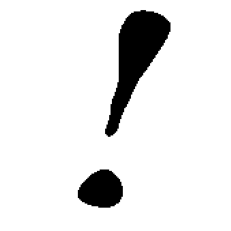

In [27]:
mask = make_low_freq_image(3, [160, 160])
mask = binarise_mask(mask, 0.9, [160, 160])
_ = plt.imshow(mask[0], cmap='gray')
_ = plt.axis('off')

In [28]:
class FMix(Callback):
    "Implementation of `https://arxiv.org/abs/2002.12047`"
    run_after, run_valid = [Normalize], False

    def __init__(self, d=3., alpha=1.):
        self.distrib = Beta(tensor(alpha), tensor(alpha))
        self.d = d

    def before_fit(self):
        # stack_y is a bool
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        # lam is related to how much white is present in the mask - higher is more
        lam = self.distrib.sample()
        lam = max(lam, 1-lam)
        # Get Image pixel dimensions
        W,H = self.xb[0].size(3),self.xb[0].size(2)
        # mask generated properly
        mask = make_low_freq_image(self.d, [W, H])
        # Binarise_mask was not properly pushed to CUDA, fix by direct conversion to a tensor float
        self.mask = torch.tensor(binarise_mask(mask, lam, [W, H]),dtype=torch.float).to(self.x.device)
        self.lam = lam.to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        # This is the application of the mask - see the multiplication by inverse
        self.learn.xb = tuple(L(self.learn.xb[0] * self.mask + xb1[0] * (1 - self.mask)))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

# Tracked Image Augmentation with EfficientNetb3 and Mish

## Quick Tracked EfficientNetb3 Baseline 100 Epochs

In [29]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

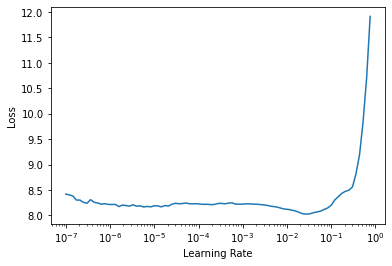

In [30]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

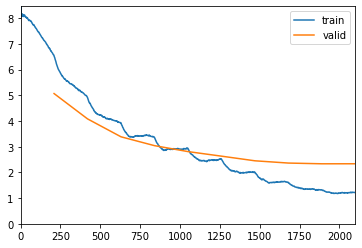

In [31]:
learn.fit_one_cycle(10, 1e-02)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=9.12010818865383e-07)

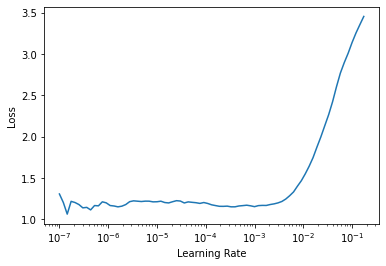

In [32]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

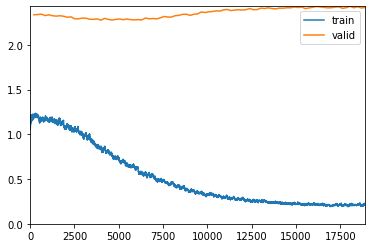

Accuracy epoch 4 :0.4802247518972563
Top-5 Accuracy epoch 4 :0.7367192060712201
Macro F1-Score Accuracy epoch 4 :0.46501483814269884
Accuracy epoch 9 :0.4865732632807939
Top-5 Accuracy epoch 9 :0.7426298890834793
Macro F1-Score Accuracy epoch 9 :0.47201787870879336
Accuracy epoch 14 :0.49321366024518387
Top-5 Accuracy epoch 14 :0.7476649153531816
Macro F1-Score Accuracy epoch 14 :0.47724481440793
Accuracy epoch 19 :0.4997081144191477
Top-5 Accuracy epoch 19 :0.7500729713952131
Macro F1-Score Accuracy epoch 19 :0.48541454648374743
Accuracy epoch 24 :0.5043782837127846
Top-5 Accuracy epoch 24 :0.7520431990659662
Macro F1-Score Accuracy epoch 24 :0.49071345200546357
Accuracy epoch 29 :0.5070782253356684
Top-5 Accuracy epoch 29 :0.7531377699941623
Macro F1-Score Accuracy epoch 29 :0.49391678987935
Accuracy epoch 34 :0.5086106246351431
Top-5 Accuracy epoch 34 :0.7537215411558669
Macro F1-Score Accuracy epoch 34 :0.49477018104889847
Accuracy epoch 39 :0.5105808523058961
Top-5 Accuracy epoch 

In [33]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'baseline_test_accuracy.csv')])

In [34]:
learn.save('effb3_baseline100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_baseline100.pth')

In [35]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5184


0.5183887915936952

## Quick Tracked Label Smoothing 100 Epoch

In [36]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           loss_func=LabelSmoothingCrossEntropy()
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

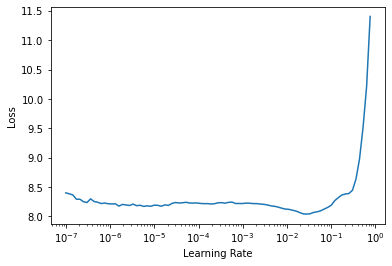

In [37]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

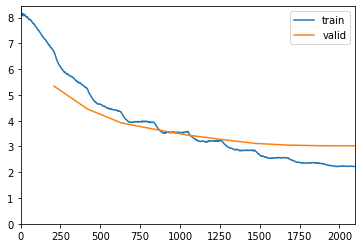

In [38]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

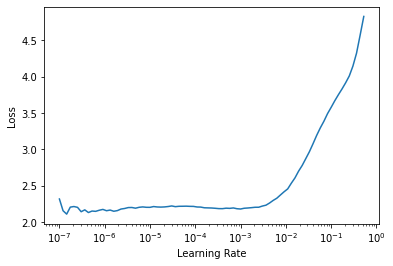

In [39]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

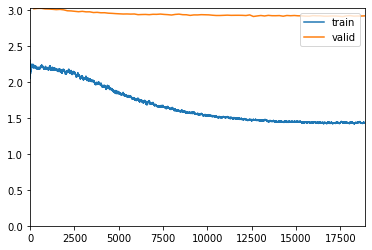

Accuracy epoch 4 :0.48679217746643316
Top-5 Accuracy epoch 4 :0.7421920607122008
Macro F1-Score Accuracy epoch 4 :0.47050231204100207
Accuracy epoch 9 :0.49241097489784
Top-5 Accuracy epoch 9 :0.7459865732632808
Macro F1-Score Accuracy epoch 9 :0.47749511152319324
Accuracy epoch 14 :0.49810274372446
Top-5 Accuracy epoch 14 :0.7514594279042616
Macro F1-Score Accuracy epoch 14 :0.48176424833948883
Accuracy epoch 19 :0.500875656742557
Top-5 Accuracy epoch 19 :0.7539404553415061
Macro F1-Score Accuracy epoch 19 :0.4856967866719303
Accuracy epoch 24 :0.5068593111500291
Top-5 Accuracy epoch 24 :0.7559836544074723
Macro F1-Score Accuracy epoch 24 :0.4918307687698174
Accuracy epoch 29 :0.5099970811441915
Top-5 Accuracy epoch 29 :0.7552539404553416
Macro F1-Score Accuracy epoch 29 :0.49655706594157417
Accuracy epoch 34 :0.5107997664915354
Top-5 Accuracy epoch 34 :0.7578809106830122
Macro F1-Score Accuracy epoch 34 :0.4965993019926054
Accuracy epoch 39 :0.5153969643899592
Top-5 Accuracy epoch 39

In [40]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'labelsmoothing_test_accuracy.csv')])

In [41]:
learn.save('effb3_labelsmoothing100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_labelsmoothing100.pth')

In [42]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5184


0.5183887915936952

## Quick Tracked Cutout 100 Epoch

In [43]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           randomerasing = RandomErasing(p=0.5, sl=0.0, sh=0.3, min_aspect=0.3, max_count=1)
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=4.786300905834651e-06)

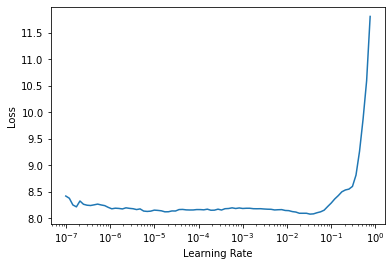

In [44]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

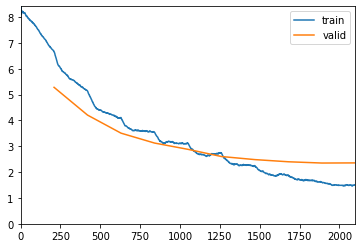

In [45]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.58489319801447e-07, lr_steep=9.12010818865383e-07)

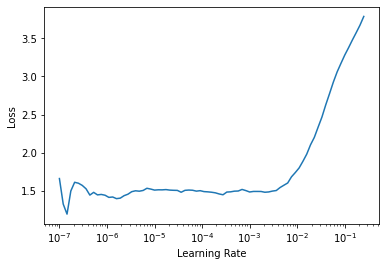

In [46]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

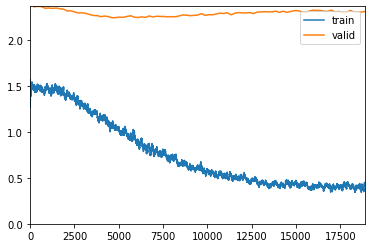

Accuracy epoch 4 :0.4752626970227671
Top-5 Accuracy epoch 4 :0.7398569760653824
Macro F1-Score Accuracy epoch 4 :0.4604221726815587
Accuracy epoch 9 :0.481903093987157
Top-5 Accuracy epoch 9 :0.7476649153531816
Macro F1-Score Accuracy epoch 9 :0.46718516858541537
Accuracy epoch 14 :0.49233800350262696
Top-5 Accuracy epoch 14 :0.7548890834792761
Macro F1-Score Accuracy epoch 14 :0.4760314054395553
Accuracy epoch 19 :0.4991243432574431
Top-5 Accuracy epoch 19 :0.7593403385872738
Macro F1-Score Accuracy epoch 19 :0.4845159917938543
Accuracy epoch 24 :0.5035026269702276
Top-5 Accuracy epoch 24 :0.7647402218330415
Macro F1-Score Accuracy epoch 24 :0.4889628929309782
Accuracy epoch 29 :0.5072241681260946
Top-5 Accuracy epoch 29 :0.7675861062463515
Macro F1-Score Accuracy epoch 29 :0.4940962504066913
Accuracy epoch 34 :0.5141564506713369
Top-5 Accuracy epoch 34 :0.7672942206654991
Macro F1-Score Accuracy epoch 34 :0.49935841028591715
Accuracy epoch 39 :0.5157618213660246
Top-5 Accuracy epoch 

In [47]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'cutout_test_accuracy.csv')])

In [48]:
learn.save('effb3_cutout100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_cutout100.pth')

In [49]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5209


0.5208698190309399

## Quick Tracked Frosted Sprinkles 100 Epoch

In [50]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           randomerasing = RandomErasing(p=1, sl=0.05, sh=0.1, min_aspect=1, max_count=25)
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=9.12010818865383e-07)

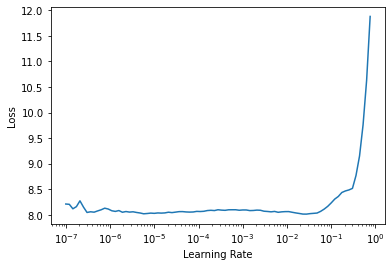

In [51]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

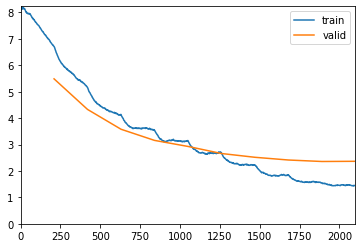

In [52]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=9.12010818865383e-07)

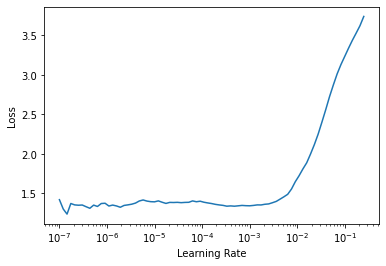

In [53]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

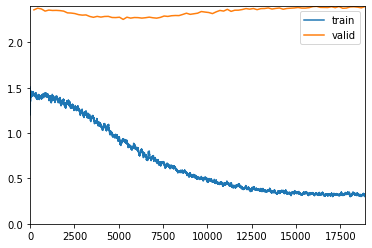

Accuracy epoch 4 :0.47343841214244015
Top-5 Accuracy epoch 4 :0.7329976649153532
Macro F1-Score Accuracy epoch 4 :0.46030802181727465
Accuracy epoch 9 :0.4791301809690601
Top-5 Accuracy epoch 9 :0.7388353765323993
Macro F1-Score Accuracy epoch 9 :0.4662265078427897
Accuracy epoch 14 :0.48620840630472856
Top-5 Accuracy epoch 14 :0.7408056042031523
Macro F1-Score Accuracy epoch 14 :0.4722906730172149
Accuracy epoch 19 :0.49430823117338
Top-5 Accuracy epoch 19 :0.7494162288382954
Macro F1-Score Accuracy epoch 19 :0.48171971720119056
Accuracy epoch 24 :0.4992702860478692
Top-5 Accuracy epoch 24 :0.7556917688266199
Macro F1-Score Accuracy epoch 24 :0.485788766847364
Accuracy epoch 29 :0.5023350846468184
Top-5 Accuracy epoch 29 :0.7572971395213076
Macro F1-Score Accuracy epoch 29 :0.48994303444193965
Accuracy epoch 34 :0.5072241681260946
Top-5 Accuracy epoch 34 :0.7612375948628137
Macro F1-Score Accuracy epoch 34 :0.49403156040796803
Accuracy epoch 39 :0.5096322241681261
Top-5 Accuracy epoch

In [54]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'frostedsprinkles_test_accuracy.csv')])

In [55]:
learn.save('effb3_frostedsprinkles100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_frostedsprinkles100.pth')

In [56]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5135


0.5134997081144191

## Quick Tracked Cutmix 100 Epoch

In [57]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

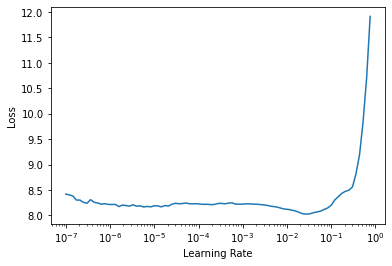

In [58]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

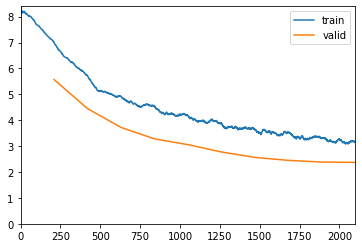

In [59]:
learn.fit_one_cycle(10, 1e-2, cbs=[CutMix(1.0)])

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

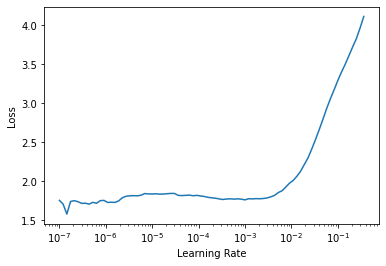

In [60]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

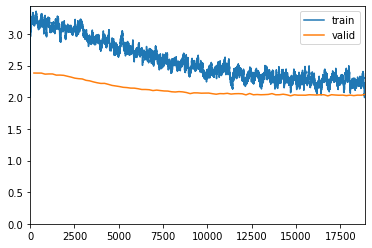

Accuracy epoch 4 :0.4708844133099825
Top-5 Accuracy epoch 4 :0.7332895504962055
Macro F1-Score Accuracy epoch 4 :0.4511787029641492
Accuracy epoch 9 :0.4760653823701109
Top-5 Accuracy epoch 9 :0.7376678342089901
Macro F1-Score Accuracy epoch 9 :0.45862743219727264
Accuracy epoch 14 :0.4882516053706947
Top-5 Accuracy epoch 14 :0.7498540572095739
Macro F1-Score Accuracy epoch 14 :0.4688007962825058
Accuracy epoch 19 :0.49584063047285465
Top-5 Accuracy epoch 19 :0.7556187974314069
Macro F1-Score Accuracy epoch 19 :0.4790164050479593
Accuracy epoch 24 :0.5070052539404554
Top-5 Accuracy epoch 24 :0.7628429655575014
Macro F1-Score Accuracy epoch 24 :0.49084972773448693
Accuracy epoch 29 :0.5088295388207823
Top-5 Accuracy epoch 29 :0.768096906012843
Macro F1-Score Accuracy epoch 29 :0.49481874393751996
Accuracy epoch 34 :0.5140105078809106
Top-5 Accuracy epoch 34 :0.7726211325160537
Macro F1-Score Accuracy epoch 34 :0.49993153168885784
Accuracy epoch 39 :0.5191185055458261
Top-5 Accuracy epoc

In [61]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'CutMix_test_accuracy.csv'), CutMix(1.0)])

In [62]:
learn.save('effb3_cutmix100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_cutmix100.pth')

In [63]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5315


0.531523642732049

## Quick Tracked FMix 100 Epoch

In [64]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

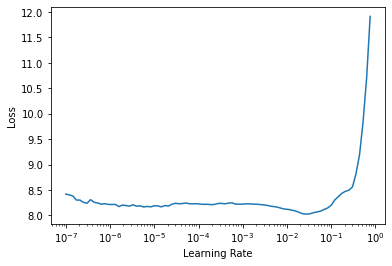

In [65]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

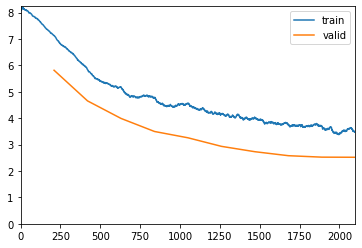

In [66]:
learn.fit_one_cycle(10, 1e-2, cbs=FMix())

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

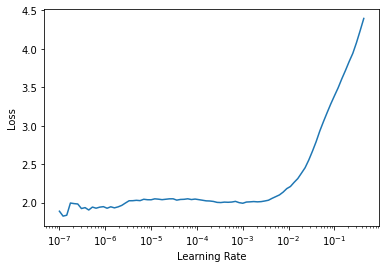

In [67]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

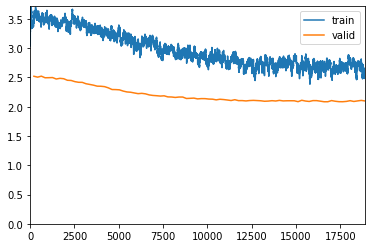

Accuracy epoch 4 :0.4564360770577933
Top-5 Accuracy epoch 4 :0.7154845300642149
Macro F1-Score Accuracy epoch 4 :0.4363416903489941
Accuracy epoch 9 :0.4635872737886748
Top-5 Accuracy epoch 9 :0.7235113835376532
Macro F1-Score Accuracy epoch 9 :0.4443013834054901
Accuracy epoch 14 :0.47256275539988324
Top-5 Accuracy epoch 14 :0.7322679509632224
Macro F1-Score Accuracy epoch 14 :0.45306304406273473
Accuracy epoch 19 :0.4816112084063047
Top-5 Accuracy epoch 19 :0.7392002335084646
Macro F1-Score Accuracy epoch 19 :0.4622969440619814
Accuracy epoch 24 :0.49657034442498543
Top-5 Accuracy epoch 24 :0.7514594279042616
Macro F1-Score Accuracy epoch 24 :0.4786508255580655
Accuracy epoch 29 :0.5021161704611792
Top-5 Accuracy epoch 29 :0.756713368359603
Macro F1-Score Accuracy epoch 29 :0.486060343121589
Accuracy epoch 34 :0.5113105662580268
Top-5 Accuracy epoch 34 :0.7654699357851722
Macro F1-Score Accuracy epoch 34 :0.4954848823180265
Accuracy epoch 39 :0.5173671920607122
Top-5 Accuracy epoch 3

In [68]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'FMix_test_accuracy.csv'), FMix()])

In [69]:
learn.save('effb3_fmix100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_fmix100.pth')

In [70]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5301


0.5300642148277875

## Quick Tracked Mixup 100 Epoch

In [71]:
# Ensure pure Mish() is used
geffnet.config.set_exportable(True)
geffnet.config.set_scriptable(False)
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit_mish(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True, act_layer='mish')
  return model

# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit_mish] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit_mish',
                           pretrained=True,
                           image_df = train_df,
                           bs = 52,
                           )

Random state set:101, cuda used: True
Image dataframe defined, reducing number of images to 25.0% and preparing stratified split.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
We have 517 classes, with a training set of size 10963, and a validation set of size 2741


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.3182567499825382e-06)

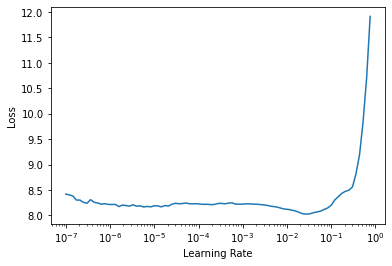

In [72]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

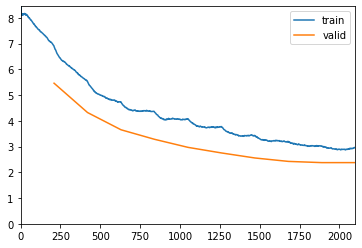

In [73]:
learn.fit_one_cycle(10, 1e-2, cbs=[MixUp(0.4)])

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

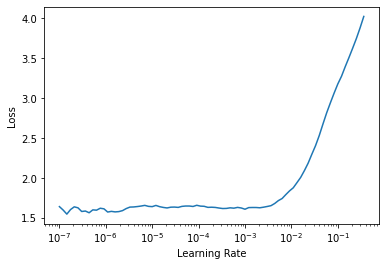

In [74]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

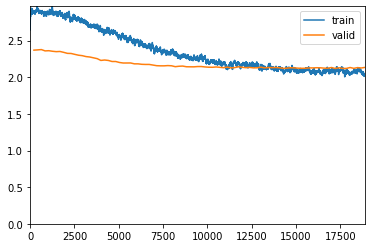

Accuracy epoch 4 :0.4743140688849971
Top-5 Accuracy epoch 4 :0.7283274956217163
Macro F1-Score Accuracy epoch 4 :0.4553857886441183
Accuracy epoch 9 :0.48029772329246934
Top-5 Accuracy epoch 9 :0.7321220081727963
Macro F1-Score Accuracy epoch 9 :0.46171264242664994
Accuracy epoch 14 :0.49022183304144773
Top-5 Accuracy epoch 14 :0.7416082895504962
Macro F1-Score Accuracy epoch 14 :0.47177377153726024
Accuracy epoch 19 :0.4979568009340339
Top-5 Accuracy epoch 19 :0.7473000583771162
Macro F1-Score Accuracy epoch 19 :0.48149726007353183
Accuracy epoch 24 :0.5061295971978984
Top-5 Accuracy epoch 24 :0.7583917104495038
Macro F1-Score Accuracy epoch 24 :0.48959201286815857
Accuracy epoch 29 :0.5094862813776999
Top-5 Accuracy epoch 29 :0.7607997664915354
Macro F1-Score Accuracy epoch 29 :0.4944589612023767
Accuracy epoch 34 :0.5150321074138937
Top-5 Accuracy epoch 34 :0.7640834792761237
Macro F1-Score Accuracy epoch 34 :0.5002431930138252
Accuracy epoch 39 :0.5144483362521891
Top-5 Accuracy ep

In [75]:
learn.fit_one_cycle(90, lr_max=slice(1e-5, 1e-4), cbs=[TestAccuracyCallback(holdout_dl=test_dl.valid, report_freq=5, fname = 'MixUp_test_accuracy.csv'), MixUp(0.4)])

In [76]:
learn.save('effb3_mixup100')

Path('/content/drive/My Drive/Houseplant Classifier/Models/effb3_mixup100.pth')

In [77]:
get_test_accuracy(learn)

Accuracy on holdout test set = 0.5223


0.5223292469352014

# Image Augmentation Visualization

## CutMix

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


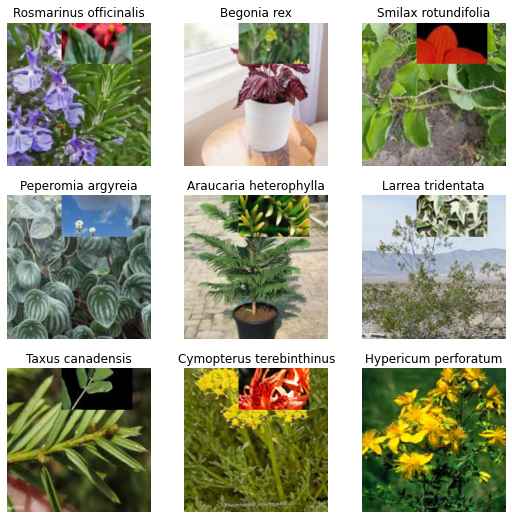

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25)

cutmix = CutMix(1.0)
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=cutmix) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


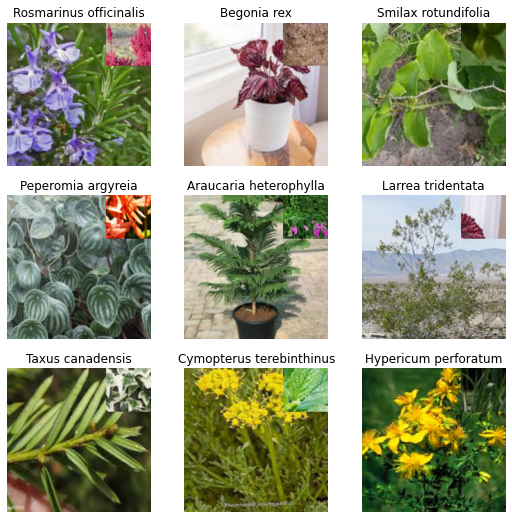

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25)

cutmix = CutMix(0.2)
# The beta distribution appears to be changing the size - hence the distribution is controlled by the parameter. 
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=cutmix) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')
    
_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())

## Mixup

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Random state set:101, cuda used: True


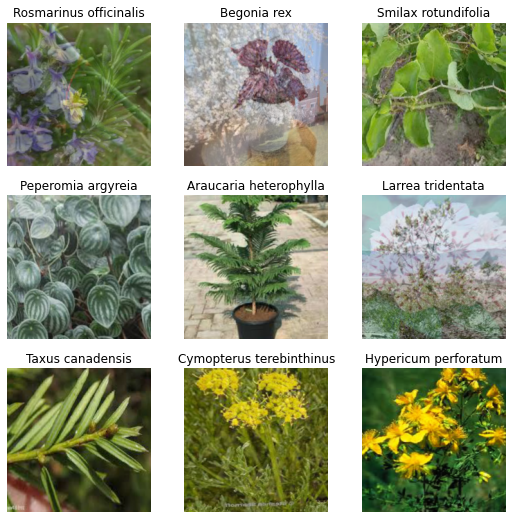

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25)

mixup = MixUp(0.4)
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=mixup) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


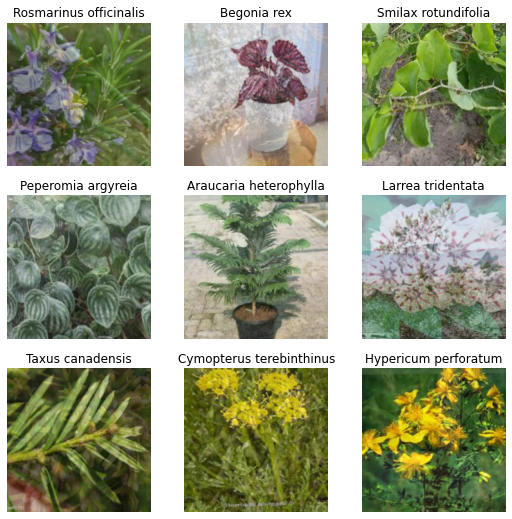

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25)

mixup = MixUp(0.999)
#Beta distribution - higher alpha as more shallow convex shape... more blending in general but the points on the x axis don't change as randomness is fixed
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=mixup) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

## Fmix

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


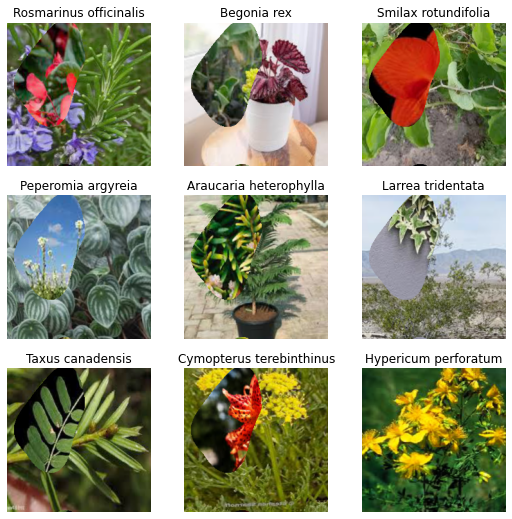

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25)

fmix = FMix()
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=fmix) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(fmix.x,fmix.y), ctxs=axs.flatten())

## Cutout

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


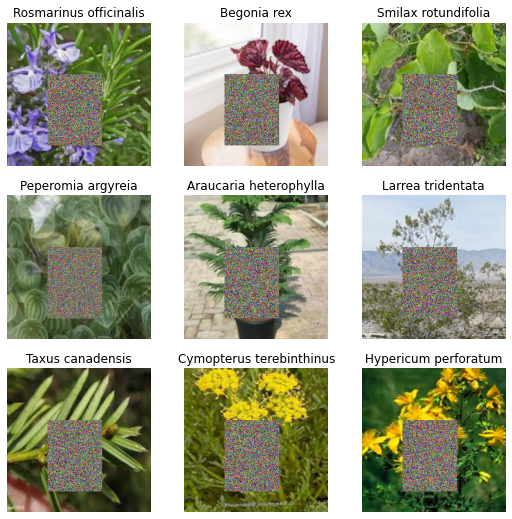

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25,
                     randomerasing = RandomErasing(p=0.5, sl=0.0, sh=0.3, min_aspect=0.3, max_count=1))

mixup = MixUp(0.01)
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=mixup) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

## Frosted Sprinkles

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Random state set:101, cuda used: True


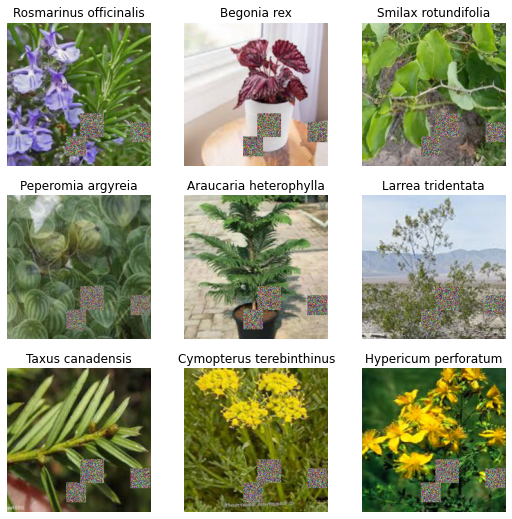

In [ ]:
random_seed(101, True)
dls = get_dataloader(img_size = 224, 
                     bs = 64,
                     img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                     split_path = '/content/plant_image_database/',
                     pct_images=0.25,
                     randomerasing = RandomErasing(p=1, sl=0.05, sh=0.1, min_aspect=1, max_count=25))

mixup = MixUp(0.01)
with cnn_learner(dls, 
                 resnet34, 
                 pretrained=True,
                 config = {},
                 opt_func=partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True),
                 metrics=[accuracy,top_k_accuracy], 
                 model_dir = '/content/drive/My Drive/Houseplant Classifier/Models/',
                 loss_func = None,
                 cbs=mixup) as learn:
    random_seed(101, True)
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

## Batch basic transforms

In [ ]:
tfms = [*aug_transforms(size=224)]

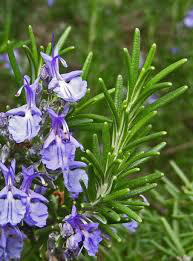

In [ ]:
path = Path('/content/plant_images_database_manualcleanedlosses10/Rosmarinus officinalis/00000009.jpg')
img = Image.open(path)
img

In [ ]:
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

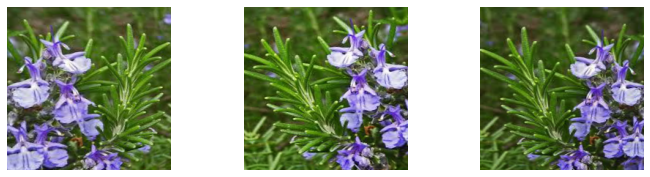

In [ ]:
y = _batch_ex(9)
for t in tfms: y = t(y, split_idx=0)
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax)